<a href="https://colab.research.google.com/github/AndyYFTao/Image-Classification-on-CIFAR-10/blob/main/Image_Classification_on_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classification on CIFAR-10
by Tao Yufeng, Cai Yuxi, Gan Dailin, Huang Yifeng



##I. Data Preprocessing

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
print(torch.__version__)

import matplotlib.pyplot as plt
import numpy as np
import torchvision
print(torchvision.__version__)

1.8.1+cu101
0.9.1+cu101


### I-1 Data Transformation
**Dataset description**: The CIFAR-10 dataset consists of 50000 training images and 10000 testing images in 10 different classes, each image having a size of 32 by 32 pixels with 3 colour channels.

In [ ]:
def normalization_para (trainset=True):
    dataset = datasets.CIFAR10(root='./data', train=trainset, download=True, transform=transforms.ToTensor())
    print(dataset.data.shape)
    norm_mean = dataset.data.mean(axis=(0,1,2))/dataset.data.max()
    norm_std_dev = dataset.data.std(axis=(0,1,2))/dataset.data.max()
    print(norm_mean)
    print(norm_std_dev)
    return norm_mean, norm_std_dev

In [ ]:
norm_mean, norm_std_dev = normalization_para()
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std_dev)
])

norm_mean, norm_std_dev = normalization_para(False)
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std_dev)
])


Extracting ./data/cifar-10-python.tar.gz to ./data
(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]
Files already downloaded and verified
(10000, 32, 32, 3)
[0.49421428 0.48513139 0.45040909]
[0.24665252 0.24289226 0.26159238]


### I-2 Data Loading

I-2-1 Training & Validation Set

In [ ]:
train_batch_size = 32
val_batch_size = 100 # TBC
log_interval = 100 
seed = 1
torch.manual_seed(seed)

In [ ]:
train_val = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainset, valset = torch.utils.data.random_split(train_val, [44000, 6000])

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=train_batch_size, shuffle=True)#, num_workers=2)
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=val_batch_size, shuffle=True)#, num_workers=2)

Files already downloaded and verified


I-2-2 Testing Set

In [ ]:
test_batch_size = 100 # TBC

In [ ]:
testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=test_batch_size, shuffle=False)#, num_workers=2)

Files already downloaded and verified


I-2-3 Classes

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

### I-3. Preview of a batch of training images

In [ ]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:  tensor([5, 9, 7, 2, 1, 8, 1, 7, 3, 0, 6, 4, 2, 6, 9, 2, 9, 3, 4, 6, 8, 3, 2, 6,
        4, 2, 3, 8, 2, 9, 9, 6])
Batch shape:  torch.Size([32, 3, 224, 224])


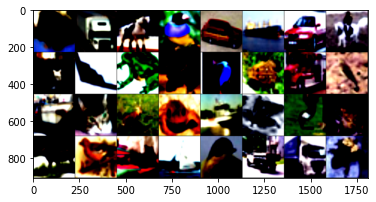

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

##II. Model Building

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
save_model = True
device

device(type='cuda')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

### II-0 Optimization setting

In [ ]:
lr = 0.001
momentum = 0.9
wd = 0.0005

In [ ]:
criterion = nn.CrossEntropyLoss()
def optimization(model, momentum, wd, lr, opti = "SGD"):
    if opti == "Adam":
        optimizer = optim.Adam(model.parameters(), weight_decay=wd,lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), momentum=momentum, weight_decay=wd,lr=lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=0, verbose=True)
    return optimizer, scheduler

###II-1 **Clairvoyance 1**: Simple Perceptron 

In [ ]:
class Clairvoyance_1(nn.Module):
    def __init__(self, input_size, num_class):
        super(Clairvoyance_1, self).__init__()
        self.fc = nn.Linear(input_size, num_class)
        self.sigmoid = torch.nn.Sigmoid() 
        # use sigmoid function as the activation function
    def forward(self, x):
        x = torch.flatten(x, 1)
        output = self.fc(x)
        output = self.sigmoid(output) 
        return output

In [ ]:
model_CV1 = Clairvoyance_1(input_size=3*224*224, num_class=10)
model_CV1 = model_CV1.to(device)
optimizer_CV1, criterion_CV1, scheduler_CV1 = optimization (model_CV1, momentum, wd, lr)

###II-2 **Clairvoyance 2**: AlexNet

Modified AlexNet implementation based on the original AlexNet model which is trained on two GPUs (https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf):    
<br> Convolutional layers <br>
1. CONV (96, $11\times11$, stride=4, pad=4) + BN + ReLU + MaxPool($3\times3$, stride=2) 
2. CONV (256, $5\times5$, stride=1, pad=2) + BN + ReLU + MaxPool($3\times3$, stride=2)    
3. CONV (384, $3\times3$, stride=1, pad=1) + BN + ReLU
4. CONV (384, $3\times3$, stride=1, pad=1) + BN + ReLU
5. CONV (256, $3\times3$, stride=1, pad=1) + BN + ReLU + MaxPool($3\times3$, stride=2) 

<br> Fully connected layers <br>
6. Dropout (0.5) + FC (4096 neurons) + ReLU  
7. Dropout (0.5)+ FC (4096 neurons) + ReLU 
8. FC: output = num_classes  

In [ ]:
class Clairvoyance_2(nn.Module):
  def __init__(self, num_classes=10):
    super(Clairvoyance_2, self).__init__()
    self.convs = nn.Sequential(
        # 1st conv
        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=4),
        nn.BatchNorm2d(96),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        
        # 2nd conv
        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        # 3rd conv
        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace=True),

        # 4th conv
        nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU(inplace=True),

        # 5th conv
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2)
      )
    self.avgpool = nn.AdaptiveAvgPool2d((6,6))

    self.fcs = nn.Sequential(
        # FC1
        nn.Dropout(0.5),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        
        # FC2
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        
        # FC3
        nn.Linear(4096, num_classes)
    )

  def forward(self, x):
    x = self.convs(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fcs(x)
    x = F.log_softmax(x, dim=1) # log_softmax addded
    return x

In [ ]:
model_CV2 = Clairvoyance_2(num_classes=len(classes))
model_CV2 = model_CV2.to(device)
optimizer_CV2, criterion_CV2, scheduler_CV2 = optimization (model_CV2, momentum, wd, lr)

###II-3 **Clairvoyance 3**: VGG

In [ ]:
def _make_features(arch):
    features = []

    last_nchannels = 3 # in_channels=3 initially
    for nlayers, nchannels in zip(*arch):
        for _ in range(nlayers):
            features.append(nn.Conv2d(in_channels=last_nchannels, out_channels=nchannels,
                                   kernel_size=3,
                                   padding=1))
            features.append(nn.BatchNorm2d(nchannels))
            features.append(nn.ReLU(inplace=True))
            last_nchannels = nchannels
        features.append(nn.MaxPool2d(kernel_size=2, stride=2))

    return nn.Sequential(*features), last_nchannels

In [ ]:
class VGG(nn.Module):
    def __init__(self, arch, nclasses=10, **kwargs):
        super(VGG, self).__init__(**kwargs)

        # first 5 blocks depending on architectures
        self.convs, last_nchannels = _make_features(arch)

        self.avgpool = nn.AdaptiveAvgPool2d((7,7))

        self.fcs = nn.Sequential(
            # FC1
            nn.Linear(last_nchannels * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            # FC2
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            # FC3
            nn.Linear(4096, nclasses)
        )

    def forward(self, x):
        x = self.convs(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fcs(x)
        x = F.log_softmax(x, dim=1) # log_softmax addded
        return x


In [ ]:
vgg_archs = {
    11: ([1, 1, 2, 2, 2], [64, 128, 256, 512, 512]),
    13: ([2, 2, 2, 2, 2], [64, 128, 256, 512, 512]),
    16: ([2, 2, 3, 3, 3], [64, 128, 256, 512, 512]),
    19: ([2, 2, 4, 4, 4], [64, 128, 256, 512, 512]),
}


def _make_vgg(nlayers, nclasses=10):
    return VGG(vgg_archs[nlayers], nclasses)


def VGG11(nclasses=10):
    return _make_vgg(11, nclasses)


def VGG13(nclasses=10):
    return _make_vgg(13, nclasses)


def VGG16(nclasses=10):
    return _make_vgg(16, nclasses)


def VGG19(nclasses=10):
    return _make_vgg(19, nclasses)

In [ ]:
model_CV3 = VGG11()
model_CV3 = model_CV3.to(device)
optimizer_CV3, criterion_CV3, scheduler_CV3 = optimization(model_CV3, momentum, wd, lr)

###II-4 **Clairvoyance 4**: ResNet

#### Basic block

Architecture:  
CONV2D(kernel size = 3*3, n filters = X) + BN + ReLU + CONV2D(kernel size = 3*3, n filters = X) + BN + (identity mapping) + ReLU

In [ ]:
class BasicBlock(nn.Module):
  
  def __init__(self, in_channel, out_channel, downsample=False, strides=1, **kwargs):
    
    super(BasicBlock, self).__init__(**kwargs)

    self.relu = nn.ReLU()

    self.block = nn.Sequential(
        nn.Conv2d(in_channels=in_channel,
                  out_channels=out_channel,
                  kernel_size=3,
                  stride=strides,
                  padding=1
                  ),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(),

        nn.Conv2d(in_channels=out_channel, 
                  out_channels=out_channel,
                  kernel_size=3,
                  padding=1),
        nn.BatchNorm2d(out_channel)
    )

    if downsample:
      self.shortcut = nn.Conv2d(in_channels=in_channel,
                                out_channels=out_channel,
                                kernel_size=1,
                                stride=strides)
    else:
      self.shortcut = None
    
  def forward(self,x):
    y = self.block(x)

    if self.shortcut:
      x = self.shortcut(x)

    return self.relu(y+x)

#### BottleNeck Block

Difference between the basic block and the bottlenet block:  
Use a stack of 3 layers instead of 2. The three layers are 1$\times$1, 3$\times$3 and 1$\times$1 convolutions, where the 1$\times$1 layers are responsible for reducing and then increasing (restoring) dimensions, leaving the 3$\times$3 layer a bottleneck with smaller input/output dimensions.

In [ ]:
class BottleNeckBlock(nn.Module):
  
  def __init__(self, in_channel, out_channel, downsample=False, strides=1, **kwargs):

    super(BottleNeckBlock, self).__init__(**kwargs)

    self.relu = nn.ReLU()

    self.mid_channel = out_channel//4

    self.block = nn.Sequential(
        nn.Conv2d(in_channels=in_channel,
                  out_channels=self.mid_channel,
                  kernel_size=1,
                  stride=strides),
        nn.BatchNorm2d(self.mid_channel),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.mid_channel,
                  out_channels=self.mid_channel,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(self.mid_channel),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.mid_channel,
                  out_channels=out_channel,
                  kernel_size=1),
        nn.BatchNorm2d(out_channel)
    )

    if downsample:
      self.shortcut = nn.Conv2d(in_channels=in_channel,
                                out_channels=out_channel,
                                kernel_size=1,
                                stride=strides)
    else:
      self.shortcut = None
    
  def forward(self, x):
    
    y = self.block(x)

    if self.shortcut:
      x = self.shortcut(x)

    return self.relu(y+x)

#### Overall architecture

In [ ]:
def _make_layer(block, nblocks, in_channels, out_channels, strides):

  layers = []

  layers.append(block(in_channels, out_channels, out_channels != in_channels, strides))
  for _ in range(nblocks - 1):
    layers.append(block(out_channels, out_channels, False))
  
  return nn.Sequential(*layers)

In [ ]:
class ResNet(nn.Module):
  def __init__(self, block, layers, channels, nclasses):
    super(ResNet, self).__init__()

    net = []

    # first layers: CONV[7*7, 64, stride 2] + [3*3 max pool, stride 2] (original paper)

    net.append(nn.Conv2d(in_channels=3,
                    out_channels=64,
                    kernel_size=3,
                    stride=1,
                    padding=1))
    net.append(nn.BatchNorm2d(64))
    net.append(nn.ReLU())
    net.append(nn.MaxPool2d(kernel_size=3,
                      stride=2,
                      padding=1))
    
    # ResNet layers
    for i, nblocks in enumerate(layers):
      strides = 1 if i == 0 else 2
      net.append(_make_layer(block, nblocks, channels[i], channels[i+1], strides))

    net.append(nn.BatchNorm2d(channels[i+1]))
    net.append(nn.ReLU())
    net.append(nn.AdaptiveAvgPool2d((1,1)))

    self.net = nn.Sequential(*net)
    self.fc = nn.Linear(channels[i+1], nclasses)
  
  def forward(self, x):
    x = self.net(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

In [ ]:
resnet_architecture = {
    18: [BasicBlock, [2, 2, 2, 2], [64, 64, 128, 256, 512]],
    34: [BasicBlock, [3, 4, 6, 3], [64, 64, 128, 256, 512]],
    50: [BottleNeckBlock, [3, 4, 6, 3], [64, 256, 512, 1024, 2048]],
    101: [BottleNeckBlock, [3, 4, 23, 3], [64, 256, 512, 1024, 2048]],
    152: [BottleNeckBlock, [3, 8, 36, 3], [64, 256, 512, 1024, 2048]]
}

In [ ]:
def ResNet18(nclasses):
  return ResNet(*resnet_architecture[18], nclasses)

def ResNet34(nclasses):
  return ResNet(*resnet_architecture[34], nclasses)

def ResNet50(nclasses):
  return ResNet(*resnet_architecture[50], nclasses)

def ResNet101(nclasses):
  return ResNet(*resnet_architecture[101], nclasses)

def ResNet152(nclasses):
  return ResNet(*resnet_architecture[152], nclasses)

####Intialization

In [ ]:
model_resnet18 = ResNet18(len(classes))
model_resnet18 = model_resnet18.to(device)
optimizer_resnet = optim.SGD(model_resnet18.parameters(),
                             lr=lr,
                             momentum=momentum,
                             weight_decay=wd)
criterion_resnet = nn.CrossEntropyLoss()
scheduler_resnet = optim.lr_scheduler.ReduceLROnPlateau(optimizer_resnet, mode='min', patience=1, verbose=True)

###II-4 **Clairvoyance 5**: DenseNet

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
class _DenseLayer(nn.Module):
    def __init__(
        self,
        num_input_features,
        growth_rate,
        bn_size
    ):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False))
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False))

    def bn_function(self, inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))
        return bottleneck_output

    def forward(self, input):  
        bottleneck_output = self.bn_function(input)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        return new_features

In [ ]:
class _DenseBlock(nn.ModuleDict):
    def __init__(
        self,
        num_layers,
        num_input_features,
        bn_size,
        growth_rate
    ):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)

In [ ]:
class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

In [ ]:
class DenseNet(nn.Module):
    def __init__(
        self,
        num_init_features,# : int = 64,
        growth_rate, #: int = 32,
        block_config,#: Tuple[int, int, int, int] = (6, 12, 24, 16), #: int = 64,
        bn_size=2,
        num_classes = 10,
        **kwargs
    ):
        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [ ]:
densenet_archs = {
    121: [64, 32, [6, 12, 24, 16]],
    161: [96, 48, [6, 12, 36, 24]],
    169: [64, 32, [6, 12, 32, 32]],
    201: [64, 32, [6, 12, 48, 32]]
}


def DenseNet121(nclasses):
    return DenseNet(*densenet_archs[121], nclasses)


def DenseNet161(nclasses):
    return DenseNet(*densenet_archs[161], nclasses)


def DenseNet169(nclasses):
    return DenseNet(*densenet_archs[169], nclasses)


def DenseNet201(nclasses):
    return DenseNet(*densenet_archs[201], nclasses)

In [ ]:
model_Dense = DenseNet121(nclasses=len(classes))
model_Dense = model_Dense.to(device)
optimizer_Dense, criterion_Dense, scheduler_Dense = optimization(model_Dense, momentum, wd, lr)

##III.Training and Testing

In [ ]:
from sklearn.metrics import f1_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt

epochs_ES = 100
epochs = 10

### III-0 Training and testing functions

In [ ]:
def train(model, device, train_loader, optimizer, loss_fcn, epoch, log_interval):
    model.train()
    loss_list_per_epoch = []
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)
        # set gradients to zero
        optimizer.zero_grad()
        outputs = model(data)
        outputs = torch.exp(outputs)
        loss = loss_fcn(outputs, target)

        # Backward
        loss.backward()

        # update parameters
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        loss_list_per_epoch.append(loss.data)

    return loss_list_per_epoch

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='ES_checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_ES_checkpoint(val_loss, model)
        elif score <= self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_ES_checkpoint(val_loss, model)
            self.counter = 0

    def save_ES_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def test(model, device, loss_fcn, test_loader, test_batch_size):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          outputs = model(data) # prediction
          outputs = torch.exp(outputs)
          _, predicted = torch.max(outputs.data, 1)
          loss = loss_fcn(outputs, target)*test_batch_size
          test_loss += loss
          correct += (predicted == target).sum().item()           
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)

In [ ]:
def class_wise_test(model, device, loss_fnc, test_loader, n_class):
  model.eval()
  confusion_matrix = torch.zeros(n_class, n_class)
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      outputs = model(data)
      _, predicted = torch.max(outputs.data, 1)
      for t, p in zip(target.view(-1), predicted.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1
  print("\nCLass wise accuracy: {}\n".format(confusion_matrix.diag()/confusion_matrix.sum(1)))
  print("\nConfusion matrix: {}\n".format(confusion_matrix))
  return confusion_matrix, confusion_matrix.diag()/confusion_matrix.sum(1)

In [ ]:
def F1_score(test_loader, model):
  n_class = 10
  f1_score_micro_summary = []
  f1_score_macro_summary = []
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      y = model(data)
      y_final = torch.argmax(y, dim=1)
      target = target.cpu().numpy().tolist()
      y_final = y_final.cpu().numpy().tolist()
      micro_ave = f1_score(target, y_final, labels = list(range(n_class)), average = "micro")
      macro_ave = f1_score(target, y_final, labels = list(range(n_class)), average = "macro")
      f1_score_micro_summary.append(micro_ave)
      f1_score_macro_summary.append(macro_ave)

  print("ave_micro_F1:", sum(f1_score_micro_summary)/len(f1_score_micro_summary))
  print("ave_macro_F1:", sum(f1_score_macro_summary)/len(f1_score_macro_summary))
  return

### III-2 Training and testing for CV2 with Early Stopping

In [ ]:
loss_list_CV2 = []
val_accuracy_list_CV2 = []
early_stopping = EarlyStopping(patience=1, verbose=True)
for epoch in range(1, epochs + 1):
    # train
    loss_list_per_epoch = train(model_CV2, device, train_loader, optimizer_CV2, criterion_CV2, epoch, log_interval)
    # inference on validation set 
    validation_loss, validation_accuracy= test(model_CV2, device, criterion_CV2, val_loader, val_batch_size)
    scheduler_CV2.step(validation_loss)
    # log loss and acc
    loss_list_CV2.append(sum(loss_list_per_epoch)/len(loss_list_per_epoch))
    val_accuracy_list_CV2.append(validation_accuracy/100)
    early_stopping(validation_loss, model_CV2)
    if early_stopping.early_stop:
      print("Early stopping")
      break
    model_CV2.load_state_dict(torch.load('ES_checkpoint.pt'))

if save_model:
    torch.save(model_CV2.state_dict(), "CIFAR_CV2.pt")

Train Epoch: 1 [0/44000 (0%)]	Loss: 2.296288
Train Epoch: 1 [3200/44000 (7%)]	Loss: 2.293002
Train Epoch: 1 [6400/44000 (15%)]	Loss: 2.306769
Train Epoch: 1 [9600/44000 (22%)]	Loss: 2.239993
Train Epoch: 1 [12800/44000 (29%)]	Loss: 2.183421
Train Epoch: 1 [16000/44000 (36%)]	Loss: 2.149536
Train Epoch: 1 [19200/44000 (44%)]	Loss: 2.149052
Train Epoch: 1 [22400/44000 (51%)]	Loss: 2.067385
Train Epoch: 1 [25600/44000 (58%)]	Loss: 2.068291
Train Epoch: 1 [28800/44000 (65%)]	Loss: 2.087118
Train Epoch: 1 [32000/44000 (73%)]	Loss: 2.114438
Train Epoch: 1 [35200/44000 (80%)]	Loss: 2.098652
Train Epoch: 1 [38400/44000 (87%)]	Loss: 2.072247
Train Epoch: 1 [41600/44000 (95%)]	Loss: 2.068602

Test set: Average loss: 2.0090, Accuracy: 2701/6000 (45%)

Validation loss decreased (inf --> 2.008952).  Saving model ...
Train Epoch: 2 [0/44000 (0%)]	Loss: 2.076296
Train Epoch: 2 [3200/44000 (7%)]	Loss: 1.966241
Train Epoch: 2 [6400/44000 (15%)]	Loss: 2.102378
Train Epoch: 2 [9600/44000 (22%)]	Loss: 2.0

In [ ]:
model_CV2.load_state_dict(torch.load("CIFAR_CV2.pt"))
model_CV2.eval()
# inference on test dataset
test_loss, test_accuracy = test(model_CV2, device, criterion_CV2, test_loader, test_batch_size)


Test set: Average loss: 1.8283, Accuracy: 6305/10000 (63%)



In [ ]:
n_class = 10
class_con_mat, class_wise_acc = class_wise_test(model_CV2, device, criterion_CV2, test_loader, n_class)


CLass wise accuracy: tensor([0.6910, 0.6810, 0.0000, 0.3540, 0.6460, 0.7390, 0.7100, 0.7460, 0.7900,
        0.9480])


Confusion matrix: tensor([[691.,  17.,   0.,  18.,  24.,  26.,  11.,  16.,  79., 118.],
        [  8., 681.,   0.,   4.,   5.,   5.,   4.,   2.,  15., 276.],
        [131.,  10.,   0.,  76., 288., 227.,  94.,  76.,  24.,  74.],
        [ 15.,   5.,   0., 354.,  87., 303.,  71.,  45.,  11., 109.],
        [ 19.,   3.,   0.,  24., 646.,  69.,  41., 146.,  19.,  33.],
        [ 12.,   0.,   0.,  60.,  43., 739.,  11.,  64.,   4.,  67.],
        [  3.,   2.,   0.,  48.,  98.,  57., 710.,  16.,   8.,  58.],
        [  6.,   1.,   0.,  13.,  44.,  97.,   6., 746.,   4.,  83.],
        [ 44.,  18.,   0.,   8.,   2.,  12.,   8.,   5., 790., 113.],
        [  7.,  14.,   0.,   4.,   2.,   5.,   3.,   2.,  15., 948.]])



In [ ]:
F1_score(test_loader, model_CV2)

ave_micro_F1: 0.6305
ave_macro_F1: 0.5869978257861063


Text(0.5, 1.0, 'CV2')

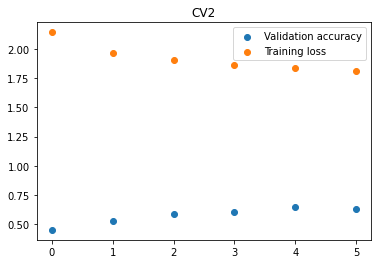

In [ ]:
val_accuracy_list_CV2 = torch.tensor(val_accuracy_list_CV2, device = 'cpu')
plt.scatter(range(len(val_accuracy_list_CV2)), val_accuracy_list_CV2, label="Validation accuracy")
plt.legend()
loss_list_CV2 = torch.tensor(loss_list_CV2, device = 'cpu')
plt.scatter(range(len(loss_list_CV2)), loss_list_CV2, label="Training loss")
plt.legend()

plt.title("CV2")

### III-4 Training and testing for CV4 without Early Stopping

In [ ]:
loss_list_resnet18 = []
val_accuracy_list_resnet18 = []

for epoch in range(1, epochs + 1):
    # train
    loss_list_per_epoch = train(model_resnet18, device, train_loader, optimizer_resnet, criterion_resnet, epoch, log_interval)
    # inference on validation set 
    validation_loss, validation_accuracy= test(model_resnet18, device, criterion_resnet, val_loader, val_batch_size)
    scheduler_resnet.step(validation_loss)
    # log loss and acc
    loss_list_resnet18.append(sum(loss_list_per_epoch)/len(loss_list_per_epoch))
    val_accuracy_list_resnet18.append(validation_accuracy/100)
    
if save_model:
    torch.save(model_resnet18.state_dict(), "CIFAR-ResNet18.pt")

Train Epoch: 1 [0/44000 (0%)]	Loss: 2.335021
Train Epoch: 1 [3200/44000 (7%)]	Loss: 2.095795
Train Epoch: 1 [6400/44000 (15%)]	Loss: 2.024582
Train Epoch: 1 [9600/44000 (22%)]	Loss: 1.936656
Train Epoch: 1 [12800/44000 (29%)]	Loss: 1.994975
Train Epoch: 1 [16000/44000 (36%)]	Loss: 1.658724
Train Epoch: 1 [19200/44000 (44%)]	Loss: 1.544218
Train Epoch: 1 [22400/44000 (51%)]	Loss: 1.488396
Train Epoch: 1 [25600/44000 (58%)]	Loss: 1.244573
Train Epoch: 1 [28800/44000 (65%)]	Loss: 1.505201
Train Epoch: 1 [32000/44000 (73%)]	Loss: 1.502788
Train Epoch: 1 [35200/44000 (80%)]	Loss: 1.346361
Train Epoch: 1 [38400/44000 (87%)]	Loss: 1.417714
Train Epoch: 1 [41600/44000 (95%)]	Loss: 1.120892

Test set: Average loss: 1.3468, Accuracy: 3378/6000 (56%)

Train Epoch: 2 [0/44000 (0%)]	Loss: 1.692948
Train Epoch: 2 [3200/44000 (7%)]	Loss: 1.194846
Train Epoch: 2 [6400/44000 (15%)]	Loss: 0.939968
Train Epoch: 2 [9600/44000 (22%)]	Loss: 1.186292
Train Epoch: 2 [12800/44000 (29%)]	Loss: 0.946989
Train Ep

In [ ]:
model_resnet18.load_state_dict(torch.load("CIFAR-ResNet18.pt"))
model_resnet18.eval()
# inference on test dataset
test_loss, test_accuracy = test(model_resnet18, device, criterion_resnet, test_loader, test_batch_size)


Test set: Average loss: 0.6823, Accuracy: 7759/10000 (78%)



In [ ]:
n_class = 10
class_con_mat, class_wise_acc = class_wise_test(model_resnet18, device, criterion_resnet, test_loader, n_class)


CLass wise accuracy: tensor([0.8560, 0.8980, 0.5570, 0.6780, 0.6770, 0.8130, 0.7420, 0.7700, 0.8740,
        0.8940])


Confusion matrix: tensor([[856.,  15.,  22.,  14.,   5.,   6.,   3.,   4.,  38.,  37.],
        [ 15., 898.,   2.,   3.,   0.,   3.,   1.,   1.,   8.,  69.],
        [ 92.,   3., 557., 122.,  41., 110.,  40.,  19.,   9.,   7.],
        [ 26.,   3.,  14., 678.,  23., 205.,  15.,   8.,  15.,  13.],
        [ 32.,   3.,  28.,  99., 677.,  67.,  29.,  54.,  10.,   1.],
        [  6.,   2.,   7., 126.,  12., 813.,   6.,  18.,   2.,   8.],
        [ 20.,   1.,  32., 139.,  15.,  38., 742.,   8.,   3.,   2.],
        [ 25.,   1.,   2.,  56.,  23., 108.,   2., 770.,   3.,  10.],
        [ 60.,  18.,   2.,   8.,   0.,   9.,   1.,   3., 874.,  25.],
        [ 18.,  38.,   4.,  13.,   0.,   3.,   0.,   4.,  26., 894.]])



In [ ]:
F1_score(test_loader, model_resnet18)

ave_micro_F1: 0.7758999999999999
ave_macro_F1: 0.7692587783373306


Text(0.5, 1.0, 'CV4')

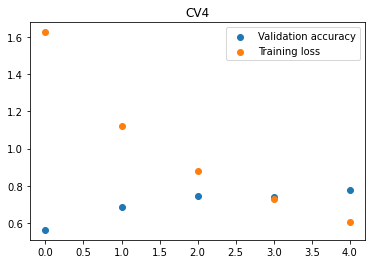

In [ ]:
val_accuracy_list_resnet18 = torch.tensor(val_accuracy_list_resnet18, device = 'cpu')
plt.scatter(range(len(val_accuracy_list_resnet18)), val_accuracy_list_resnet18, label="Validation accuracy")
plt.legend()
loss_list_resnet18 = torch.tensor(loss_list_resnet18, device = 'cpu')
plt.scatter(range(len(loss_list_resnet18)), loss_list_resnet18, label="Training loss")
plt.legend()

plt.title("CV4")